In [1]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction import FeatureHasher
import random
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_val_predict,cross_validate
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import svm

logging.getLogger().setLevel('INFO')

### Helpers

In [2]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

### Download the dataset

In [9]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)

files, directory = ATP_URLS, ATP_DIR
for dl_path in files:
    logging.info("downloading & extracting file %s", dl_path)
    archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
    download_file(dl_path, archive_path)
    extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])

INFO:root:downloading & extracting file http://tennis-data.co.uk/2000/2000.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2001/2001.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2002/2002.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2003/2003.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2004/2004.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2005/2005.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2006/2006.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2007/2007.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2008/2008.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2009/2009.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2010/2010.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2011/2011.zip
INFO:root:downloading & extracting file http://tenni

In [10]:
df_atp.head(10)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Gambill J.M.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Grosjean S.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Henman T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Hewitt L.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Lisnard J.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_atp.shape

(52298, 54)

We will drop the duplicates if they exist

In [12]:
df_atp.drop_duplicates(inplace = True)
df_atp.reset_index(drop=True, inplace=True)

In [13]:
df_atp.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'W1', 'L1',
       'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets',
       'Comment', 'CBW', 'CBL', 'GBW', 'GBL', 'IWW', 'IWL', 'SBW', 'SBL',
       'B365W', 'B365L', 'B&WW', 'B&WL', 'EXW', 'EXL', 'PSW', 'PSL', 'WPts',
       'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW', 'MaxL',
       'AvgW', 'AvgL'],
      dtype='object')

### Defining some visualisation functions

In [14]:
def density_plot(column, title, x_label):
    sns.distplot(column, hist=False)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel('Density')

In [15]:
def scatter_plot(x,y,x_label,y_label):
    plt.scatter(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

## 1. Data preprocessing

### 1.1. Exploring  the dateset

In [16]:
df_atp.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'W1', 'L1',
       'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets',
       'Comment', 'CBW', 'CBL', 'GBW', 'GBL', 'IWW', 'IWL', 'SBW', 'SBL',
       'B365W', 'B365L', 'B&WW', 'B&WL', 'EXW', 'EXL', 'PSW', 'PSL', 'WPts',
       'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW', 'MaxL',
       'AvgW', 'AvgL'],
      dtype='object')

When predicting the outcome of a tennis match, we will have the data relative to the players,the tournament and the match but we won't have the data relative to the outcome of the match since that's what we are trying to predict, so we will drop all the columns relative to the outcome match except for the winner and the loser of the match

In [17]:
df_atp.drop(['L1', 'L2', 'L3', 'L4', 'L5','Lsets', 'W1', 'W2', 'W3', 'W4', 'W5','Wsets'], inplace=True, axis=1)

We will extract the year of every match

In [18]:
df_atp['year'] = pd.DatetimeIndex(df_atp['Date']).year
df_atp = df_atp.sort_values(by='Date')
df_atp = df_atp.reset_index(drop=True)

In [19]:
df_atp.isnull().sum()

ATP               0
Location          0
Tournament        0
Date              0
Series            0
Court             0
Surface           0
Round             0
Best of           0
Winner            0
Loser             0
WRank            15
LRank            78
Comment           0
CBW           34792
CBL           34792
GBW           47243
GBL           47243
IWW           38940
IWL           38940
SBW           46874
SBL           46874
B365W          8655
B365L          8632
B&WW          51201
B&WL          51201
EXW           12887
EXL           12882
PSW           14959
PSL           14959
WPts          16204
LPts          16263
UBW           41627
UBL           41627
LBW           24167
LBL           24156
SJW           36726
SJL           36719
MaxW          29553
MaxL          29553
AvgW          29553
AvgL          29553
year              0
dtype: int64

In [20]:
df_atp.dtypes

ATP                    int64
Location              object
Tournament            object
Date          datetime64[ns]
Series                object
Court                 object
Surface               object
Round                 object
Best of                int64
Winner                object
Loser                 object
WRank                 object
LRank                 object
Comment               object
CBW                  float64
CBL                  float64
GBW                  float64
GBL                  float64
IWW                  float64
IWL                  float64
SBW                  float64
SBL                  float64
B365W                float64
B365L                float64
B&WW                 float64
B&WL                 float64
EXW                   object
EXL                  float64
PSW                  float64
PSL                  float64
WPts                 float64
LPts                 float64
UBW                  float64
UBL                  float64
LBW           

In [21]:
odds = [ 'AvgL', 'AvgW','MaxL', 'MaxW', 'B&WL', 'B&WW', 'B365L', 'B365W','CBL', 'CBW', 'EXL', 'EXW', 'GBL', 'GBW',
       'IWL', 'IWW', 'LBL', 'LBW', 'PSL', 'PSW',  'SBL', 'SBW', 'SJL', 'SJW','UBL', 'UBW']
data = ['ATP', 'Location','Tournament','Best of', 'Series', 'Surface','Date','Comment', 'Court', 'Round',  
        'Loser', 'LPts', 'LRank','Winner', 'WPts', 'WRank','year']

In [22]:
df_atp[data].describe()

,ATP,Best of,LPts,WPts,year
count,52298.000000,52298.000000,36035.000000,36094.000000,52298.000000
mean,33.222532,3.372366,1047.544665,1831.891644,2008.760526
std,18.115493,0.778516,1213.773168,2294.307489,5.494070
min,1.000000,3.000000,1.000000,1.000000,2000.000000
25%,19.000000,3.000000,496.000000,640.000000,2004.000000
50%,33.000000,3.000000,736.000000,1007.000000,2009.000000
75%,49.000000,3.000000,1141.000000,1895.000000,2014.000000
max,69.000000,5.000000,16950.000000,16950.000000,2018.000000


In [23]:
df_atp[odds].describe()

,AvgL,AvgW,MaxL,MaxW,B&WL,B&WW,B365L,B365W,CBL,CBW,...,LBL,LBW,PSL,PSW,SBL,SBW,SJL,SJW,UBL,UBW
count,22745.000000,22745.000000,22745.000000,22745.000000,1097.000000,1097.000000,43666.000000,43643.000000,17506.000000,17506.000000,...,28142.000000,28131.000000,37339.000000,37339.000000,5424.000000,5424.000000,15579.000000,15572.000000,10671.000000,10671.000000
mean,3.594448,1.834821,8.326076,1.998610,2.547347,1.728633,3.551805,1.823768,3.000658,1.812080,...,3.451461,1.810226,4.186818,1.926742,2.672064,1.793035,3.557943,1.796538,3.542479,1.815867
std,3.282610,1.107884,397.235666,1.628982,1.330386,0.730434,3.527564,1.100806,2.032791,0.868254,...,3.075889,1.031691,5.581127,1.334797,1.424672,0.751026,3.272510,1.004273,3.646316,0.996238
min,1.010000,1.010000,1.010000,1.010000,1.020000,1.010000,1.002000,1.000000,1.020000,1.000000,...,1.000000,1.000000,1.010000,1.000000,0.000000,0.000000,1.010000,1.000000,1.020000,1.010000
25%,1.740000,1.240000,1.850000,1.290000,1.600000,1.250000,1.720000,1.222000,1.720000,1.280000,...,1.730000,1.250000,1.794000,1.270000,1.670000,1.333000,1.730000,1.220000,1.750000,1.240000
50%,2.550000,1.500000,2.780000,1.570000,2.150000,1.500000,2.500000,1.500000,2.375000,1.550000,...,2.500000,1.500000,2.660000,1.550000,2.250000,1.571000,2.630000,1.500000,2.500000,1.500000
75%,3.990000,2.060000,4.540000,2.200000,3.100000,1.950000,4.000000,2.075000,3.400000,2.050000,...,4.000000,2.000000,4.240000,2.140000,3.000000,2.100000,4.000000,2.000000,3.850000,2.030000
max,36.440000,23.450000,42586.000000,76.000000,9.000000,7.500000,101.000000,29.000000,25.000000,14.000000,...,51.000000,26.000000,121.000000,46.000000,13.000000,9.000000,81.000000,19.000000,60.000000,18.000000


### 1.2. Splittting the dataset

We will test on the year 2017

In [24]:
test = df_atp.loc[df_atp['year'] == 2017]

In [25]:
df_atp = df_atp.loc[df_atp['year'] != 2017]

### 1.3. Dealing with missing Data

##### LRank and WRank

The features 'LRank' and 'WRank' are objects when they should be integers. We are going to identify the reason and fix it

In [26]:
numeric_types = [int, float, complex]
print([x for x in df_atp['WRank'] if type(x) not in numeric_types])
print([x for x in df_atp['LRank'] if type(x) not in numeric_types])

['NR']
['NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR']


The rank of non ranked players ('NR') will be replaced by 2000 since the actual maximum rank is less than 2000.

In [27]:
df_atp.loc[:,'LRank'] = df_atp.loc[:,'LRank'].replace('NR', 2000)
df_atp.loc[:,'WRank'] = df_atp.loc[:,'WRank'].replace('NR', 2000)

test.loc[:,'LRank'] = test.loc[:,'LRank'].replace('NR', 2000)
test.loc[:,'WRank'] = test.loc[:,'WRank'].replace('NR', 2000)

The proportion of missing values in the training set for the columns LRank and WRank compared to the number of entries in our data is very small, so we can delete. For the test set, we are going to replace them with the mean.

In [28]:
df_atp = df_atp.dropna(subset=['LRank', 'WRank'])

In [29]:
imp = SimpleImputer(strategy='mean')
test[['LRank', 'WRank']] =  imp.fit_transform(test[['LRank', 'WRank']])

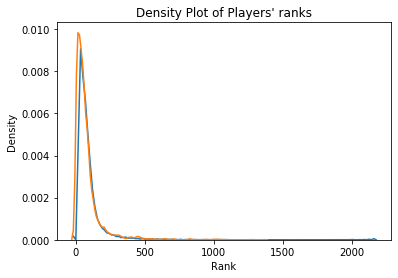

In [30]:
density_plot(pd.concat([df_atp['LRank'],df_atp['WRank']]), "Density Plot of Players' ranks", 'Rank')
density_plot(pd.concat([test['LRank'],test['WRank']]), "Density Plot of Players' ranks", 'Rank')

##### Date

In [31]:
df_atp.loc[:,'Date']= pd.to_datetime(df_atp['Date'],format='%Y-%m-%d')
test.loc[:,'Date']= pd.to_datetime(test['Date'],format='%Y-%m-%d')

##### WPts and LPts

We will visualize the variation of WPts and LPts for a certain player over the time. We will choose 'Federer R.' since we have an important number of matches played by him

Text(0.5, 1.0, 'WPts and LPts for Federer R.')

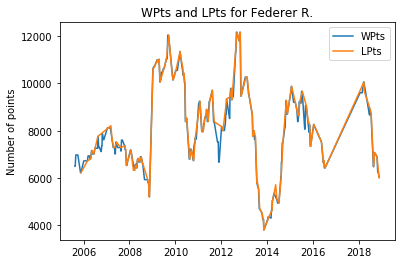

In [32]:
fig, ax = plt.subplots()
ax.plot(df_atp.loc[(df_atp['Winner']=='Federer R.')]['Date'],df_atp.loc[df_atp['Winner']=='Federer R.']['WPts'], label='WPts')
ax.plot(df_atp.loc[(df_atp['Loser']=='Federer R.')]['Date'],df_atp.loc[df_atp['Loser']=='Federer R.']['LPts'], label='LPts')
ax.legend()
plt.ylabel('Number of points')
plt.title('WPts and LPts for Federer R.')

We can fill the missing values of the LPtw and WPts by linearly interpolating them. To do that, we will start by constructing a new dataframe with the player, the date and the points of that player at that specefic date.  We will sort the new dataset by date and fill the missing values by interpolation. If the interpolation doesn't fill all the missing values, the remaining ones will be filled by the mean. We will then fill our initial dataset by the new values. 

In [33]:
playerPoints = pd.DataFrame()
playerPoints['player'] = pd.concat([df_atp['Winner'],df_atp['Loser']])                                    
playerPoints['points'] = pd.concat([df_atp['WPts'],df_atp['LPts']])                                    
playerPoints['Date'] = pd.concat([df_atp['Date'],df_atp['Date']])

In [34]:
playerPoints.drop_duplicates(['player','Date'], keep='first', inplace = True)

In [35]:
playerPoints.shape

(89541, 3)

We are going to sort the playerPoints dataset by Date to make the imputing of the missing values easier

In [36]:
playerPoints = playerPoints.sort_values(by='Date')
playerPoints = playerPoints.reset_index(drop=True)

Let's visualize the variation of the number of points of a certain player (Federer R.) over the time

Text(0.5, 1.0, 'Number of points for Federer R.')

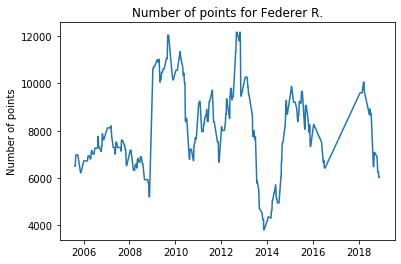

In [37]:
plt.plot(playerPoints.loc[playerPoints['player']=='Federer R.']['Date'],playerPoints.loc[playerPoints['player']=='Federer R.']['points'])
plt.ylabel('Number of points')
plt.title('Number of points for Federer R.')

In [38]:
players = playerPoints.player.unique()
for p in players:
    playerPoints.loc[playerPoints['player'] == p] = playerPoints.loc[playerPoints['player'] == p].interpolate(method ='linear', limit_direction ='both') 

Text(0.5, 1.0, 'Number of points for Federer R.')

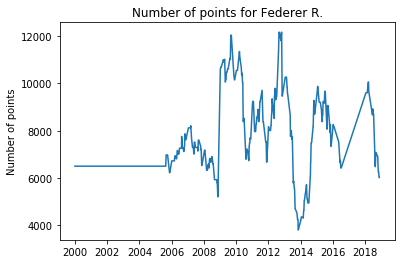

In [39]:
plt.plot(playerPoints.loc[playerPoints['player']=='Federer R.']['Date'],playerPoints.loc[playerPoints['player']=='Federer R.']['points'])
plt.ylabel('Number of points')
plt.title('Number of points for Federer R.')

In [40]:
imp_mean = SimpleImputer(strategy='mean')
playerPoints[['points']] =  imp_mean.fit_transform(playerPoints[['points']])

In [41]:
dictPlayerPoints = playerPoints.set_index(['player', 'Date']).to_dict('index')

In [42]:
dictPlayerPoints

{('Dosedel S.',
  Timestamp('2000-01-03 00:00:00')): {'points': 1316.1072646056189},
 ('Huet S.', Timestamp('2000-01-03 00:00:00')): {'points': 1316.1072646056189},
 ('Pozzi G.',
  Timestamp('2000-01-03 00:00:00')): {'points': 1316.1072646056189},
 ('Hrbaty D.', Timestamp('2000-01-03 00:00:00')): {'points': 1206.0},
 ('Goldstein P.', Timestamp('2000-01-03 00:00:00')): {'points': 435.0},
 ('Ishii Y.',
  Timestamp('2000-01-03 00:00:00')): {'points': 1316.1072646056189},
 ('Sanchez J.',
  Timestamp('2000-01-03 00:00:00')): {'points': 1316.1072646056189},
 ('Siemerink J.',
  Timestamp('2000-01-03 00:00:00')): {'points': 1316.1072646056189},
 ('Ivanisevic G.',
  Timestamp('2000-01-03 00:00:00')): {'points': 1316.1072646056189},
 ('Vicente F.', Timestamp('2000-01-03 00:00:00')): {'points': 353.0},
 ('Draper S.',
  Timestamp('2000-01-03 00:00:00')): {'points': 1316.1072646056189},
 ('Blanco G.', Timestamp('2000-01-03 00:00:00')): {'points': 122.0},
 ('Burgsmuller L.', Timestamp('2000-01-03 00

In [43]:
def getPoints(player,date):
        return(dictPlayerPoints[player, date]['points'])

In [44]:
df_atp.loc[:,'WPts'] = df_atp.apply(lambda row: getPoints(row['Winner'], row['Date']), axis=1)
df_atp.loc[:,'LPts'] = df_atp.apply(lambda row: getPoints(row['Loser'], row['Date']), axis=1)

In [45]:
df_atp[['LPts','WPts']].isnull().sum()

LPts    0
WPts    0
dtype: int64

Text(0.5, 1.0, 'WPts for Federer R.')

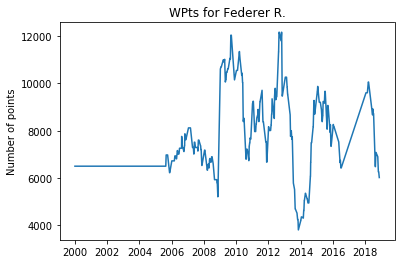

In [46]:
plt.plot(df_atp.loc[(df_atp['Winner']=='Federer R.')]['Date'],df_atp.loc[df_atp['Winner']=='Federer R.']['WPts'])
plt.ylabel('Number of points')
plt.title('WPts for Federer R.')

Now we are going to replace the missing values in the test set using the same steps

In [47]:
playerPointstest = pd.DataFrame()
playerPointstest['player'] = pd.concat([test['Winner'],test['Loser']])                                    
playerPointstest['points'] = pd.concat([test['WPts'],test['LPts']])                                    
playerPointstest['Date'] = pd.concat([test['Date'],test['Date']])

In [48]:
playerPoints = pd.concat([playerPoints,playerPointstest])

In [49]:
playerPoints.drop_duplicates(['player','Date'], keep='first', inplace = True)

In [50]:
playerPoints = playerPoints.sort_values(by='Date')
playerPoints = playerPoints.reset_index(drop=True)

In [51]:
players = playerPoints.player.unique()
for p in players:
    playerPoints.loc[playerPoints['player'] == p] = playerPoints.loc[playerPoints['player'] == p].interpolate(method ='linear', limit_direction ='both') 

In [52]:
playerPoints[['points']] =  imp_mean.fit_transform(playerPoints[['points']])

In [53]:
dictPlayerPoints = playerPoints.set_index(['player', 'Date']).to_dict('index')

In [54]:
test.loc[:,'WPts'] = test.apply(lambda row: getPoints(row['Winner'], row['Date']), axis=1)
test.loc[:,'LPts'] = test.apply(lambda row: getPoints(row['Loser'], row['Date']), axis=1)

In [55]:
test[['LPts','WPts']].isnull().sum()

LPts    0
WPts    0
dtype: int64

##### odds

Since we have an important number of sources for the odds, and since they contain a very important number of missing values, we will aggregate them in a small number of features.

1. For the mean:
    a. We will create two columns AvgOddsL and AvgOddsW representing the mean of the betting odds from different sources for every player on every match
    b. We will make the mean of the average ods that we calculated and the ones provided by the dataset (AvgOddsW with AvgW and AvgOddsL with AvgL)
    
2. For the max:
    a. We will create two columns MaxOddsL and MaxOddsW representing the max of the betting odds from different sources for every player on every match
    b. We will impute the missing values of MaxL and MaxW with the values of MaxOddsL and MaxOddsW

3. We will delete the initial values
4. We will impute the remaining values with the median

In [56]:
oddsW = [ 'B&WW', 'B365W', 'CBW', 'EXW', 'GBW', 'IWW', 'LBW', 'PSW', 'SBW', 'SJW', 'UBW']
oddsL = [ 'B&WL', 'B365L', 'CBL', 'EXL', 'GBL', 'IWL', 'LBL', 'PSL', 'SBL', 'SJL', 'UBL']

* The mean

In [57]:
df_atp.loc[:,'EXW'] = pd.to_numeric(df_atp.loc[:,'EXW'],errors='coerce')
test.loc[:,'EXW'] = pd.to_numeric(test.loc[:,'EXW'],errors='coerce')

In [58]:
df_atp.loc[:,'AvgOddsL'] = df_atp.loc[:,oddsL].mean(axis=1)
df_atp.loc[:,'AvgOddsW'] = df_atp.loc[:,oddsW].mean(axis=1)

test.loc[:,'AvgOddsL'] = test.loc[:,oddsL].mean(axis=1)
test.loc[:,'AvgOddsW'] = test.loc[:,oddsW].mean(axis=1)

In [59]:
print("    * Train")
print(df_atp[['AvgOddsL','AvgOddsW']].isnull().sum())
print(df_atp[['AvgL','AvgW']].isnull().sum())
print("    * Test")
print(test[['AvgOddsL','AvgOddsW']].isnull().sum())
print(test[['AvgL','AvgW']].isnull().sum())

    * Train
AvgOddsL    3905
AvgOddsW    3905
dtype: int64
AvgL    29500
AvgW    29500
dtype: int64
    * Test
AvgOddsL    5
AvgOddsW    5
dtype: int64
AvgL    3
AvgW    3
dtype: int64


In [60]:
df_atp.loc[:,'AvgL'] = df_atp.loc[:,['AvgL','AvgOddsL']].mean(axis=1)
df_atp.loc[:,'AvgW'] = df_atp.loc[:,['AvgW','AvgOddsW']].mean(axis=1)

test.loc[:,'AvgL'] = test.loc[:,['AvgL','AvgOddsL']].mean(axis=1)
test.loc[:,'AvgW'] = test.loc[:,['AvgW','AvgOddsW']].mean(axis=1)

In [61]:
print("    * Train")
print(df_atp[['AvgL','AvgW']].isnull().sum())
print("    * Test")
print(test[['AvgL','AvgW']].isnull().sum())

    * Train
AvgL    3884
AvgW    3884
dtype: int64
    * Test
AvgL    3
AvgW    3
dtype: int64


* The max

In [62]:
df_atp.loc[:,'MaxOddsL'] = df_atp.loc[:,oddsL].max(axis=1)
df_atp.loc[:,'MaxOddsW'] = df_atp.loc[:,oddsW].max(axis=1)

test.loc[:,'MaxOddsL'] = test.loc[:,oddsL].max(axis=1)
test.loc[:,'MaxOddsW'] = test.loc[:,oddsW].max(axis=1)

In [63]:
df_atp.loc[:,'MaxL'].fillna(df_atp['MaxOddsL'], inplace=True)
df_atp.loc[:,'MaxW'].fillna(df_atp['MaxOddsW'], inplace=True)

test.loc[:,'MaxL'].fillna(test['MaxOddsL'], inplace=True)
test.loc[:,'MaxW'].fillna(test['MaxOddsW'], inplace=True)

In [64]:
print("    * Train")
print(df_atp[['MaxL','MaxW']].isnull().sum())
print("    * Test")
print(test[['MaxL','MaxW']].isnull().sum())

    * Train
MaxL    3884
MaxW    3884
dtype: int64
    * Test
MaxL    3
MaxW    3
dtype: int64


* Deleting the unused columns

In [65]:
df_atp.drop(oddsL+oddsW+['MaxOddsL','MaxOddsW','AvgOddsL','AvgOddsW'], inplace=True, axis=1)
test.drop(oddsL+oddsW+['MaxOddsL','MaxOddsW','AvgOddsL','AvgOddsW'], inplace=True, axis=1)

In [66]:
df_atp.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'Comment',
       'WPts', 'LPts', 'MaxW', 'MaxL', 'AvgW', 'AvgL', 'year'],
      dtype='object')

In [67]:
df_atp[['MaxL','MaxW','AvgL','AvgW']].describe()

,MaxL,MaxW,AvgL,AvgW
count,45692.000000,45692.000000,45692.000000,45692.000000
mean,5.966609,1.946517,3.364696,1.812361
std,280.290444,1.350180,3.063397,0.990003
min,1.010000,1.010000,1.008200,1.004400
25%,1.820000,1.300000,1.727950,1.260000
50%,2.630000,1.580000,2.446000,1.516667
75%,4.100000,2.180000,3.690000,2.036250
max,42586.000000,76.000000,47.240000,25.280000


* Imputing with the median

In [68]:
odds = ['MaxL','MaxW','AvgL','AvgW']
imp_mean = SimpleImputer(strategy='median')
df_atp.loc[:,odds] =  imp_mean.fit_transform(df_atp[odds])
test.loc[:,odds] =  imp_mean.fit_transform(test[odds])

In [69]:
print("    * Train")
print(df_atp[odds].isnull().sum())
print("    * Test")
print(test[odds].isnull().sum())

    * Train
MaxL    0
MaxW    0
AvgL    0
AvgW    0
dtype: int64
    * Test
MaxL    0
MaxW    0
AvgL    0
AvgW    0
dtype: int64


### 1.4. Preparing the features

#### Transforming the date

In [70]:
df_atp['Month'] = pd.DatetimeIndex(df_atp['Date']).month
test['Month'] = pd.DatetimeIndex(test['Date']).month

In [71]:
df_atp.drop(['Date'], inplace=True, axis=1)
test.drop(['Date'], inplace=True, axis=1)

#### Encoding categoorical features

In [72]:
df_atp.dtypes

ATP             int64
Location       object
Tournament     object
Series         object
Court          object
Surface        object
Round          object
Best of         int64
Winner         object
Loser          object
WRank         float64
LRank         float64
Comment        object
WPts          float64
LPts          float64
MaxW          float64
MaxL          float64
AvgW          float64
AvgL          float64
year            int64
Month           int64
dtype: object

Since the rounds follow a certain order, we will map them to their logical values

In [73]:
df_atp['Round']=df_atp['Round'].map({'Round Robin':0, '1st Round':1,'2nd Round':2,'3rd Round':3,'4th Round':4, 'Quarterfinals':5,
                             'Semifinals':6,'The Final':7,'Sep':8,'Dec':9})

test['Round']=test['Round'].map({'Round Robin':0, '1st Round':1,'2nd Round':2,'3rd Round':3,'4th Round':4, 'Quarterfinals':5,
                             'Semifinals':6,'The Final':7,'Sep':8,'Dec':9})

One hot encoding the features Comment, Court, Series and Surface since they are non ordinal categorical features with a relatively low number of unique values

In [74]:
df_atp.isnull().sum()

ATP           0
Location      0
Tournament    0
Series        0
Court         0
Surface       0
Round         0
Best of       0
Winner        0
Loser         0
WRank         0
LRank         0
Comment       0
WPts          0
LPts          0
MaxW          0
MaxL          0
AvgW          0
AvgL          0
year          0
Month         0
dtype: int64

In [75]:
leComment = LabelEncoder()
df_atp['Comment_encoded'] = leComment.fit_transform(df_atp['Comment'])
test['Comment_encoded'] = leComment.transform(test['Comment'])

leCourt = LabelEncoder()
df_atp['Court_encoded'] = leCourt.fit_transform(df_atp['Court'])
test['Court_encoded'] = leCourt.transform(test['Court'])

leSeries = LabelEncoder()
df_atp['Series_encoded'] = leSeries.fit_transform(df_atp['Series'])
test['Series_encoded'] = leSeries.transform(test['Series'])

leSurface = LabelEncoder()
df_atp['Surface_encoded'] = leSurface.fit_transform(df_atp['Surface'])
test['Surface_encoded'] = leSurface.transform(test['Surface'])

In [76]:
oheComment = OneHotEncoder(categories='auto', drop='first')
XComment = oheComment.fit_transform(df_atp[["Comment_encoded"]]).toarray()
XCommentTest = oheComment.transform(test[["Comment_encoded"]]).toarray()

oheCourt = OneHotEncoder(categories='auto', drop='first')
XCourt = oheCourt.fit_transform(df_atp[["Court_encoded"]]).toarray()
XCourtTest = oheCourt.transform(test[["Court_encoded"]]).toarray()

oheSeries = OneHotEncoder(categories='auto', drop='first')
XSeries = oheSeries.fit_transform(df_atp[["Series_encoded"]]).toarray()
XSeriesTest = oheSeries.transform(test[["Series_encoded"]]).toarray()

oheSurface = OneHotEncoder(categories='auto', drop='first')
XSurface = oheSurface.fit_transform(df_atp[["Surface_encoded"]]).toarray()
XSurfaceTest = oheSurface.transform(test[["Surface_encoded"]]).toarray()

In [77]:
df_atp.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [78]:
dfComment = pd.DataFrame(XComment, columns =  ["Comment_"+str(int(i)) for i in oheComment.categories_[0][1:] ])
testComment = pd.DataFrame(XCommentTest, columns = ["Comment_"+str(int(i)) for i in oheComment.categories_[0][1:]])
df_atp = pd.concat([df_atp, dfComment], axis=1)
test = pd.concat([test, testComment], axis=1)


dfCourt = pd.DataFrame(XCourt, columns =  ["Court_"+str(int(i)) for i in oheCourt.categories_[0][1:] ])
testCourt = pd.DataFrame(XCourtTest, columns = ["Court_"+str(int(i)) for i in oheCourt.categories_[0][1:]])
df_atp = pd.concat([df_atp, dfCourt], axis=1)
test = pd.concat([test, testCourt], axis=1)


dfSeries = pd.DataFrame(XSeries, columns = ["Series_"+str(int(i)) for i in oheSeries.categories_[0][1:]])
testSeries = pd.DataFrame(XSeriesTest, columns = ["Series_"+str(int(i)) for i in oheSeries.categories_[0][1:]])
df_atp = pd.concat([df_atp, dfSeries], axis=1)
test = pd.concat([test, testSeries], axis=1)


dfSurface = pd.DataFrame(XSurface, columns = ["Surface_"+str(int(i)) for i in oheSurface.categories_[0][1:]])
testSurface = pd.DataFrame(XSurfaceTest, columns = ["Surface_"+str(int(i)) for i in oheSurface.categories_[0][1:]])
df_atp = pd.concat([df_atp, dfSurface], axis=1)
test = pd.concat([test, testSurface], axis=1)

Hash the features Location and Tournament since they are non ordinal categorical features a very important number of unique values

In [79]:
fhLoc = FeatureHasher(n_features=4, input_type='string')
hashed_locations = fhLoc.fit_transform(df_atp['Location'].astype(str))
hashed_locations_test = fhLoc.transform(test['Location'].astype(str))
hashed_locations = hashed_locations.toarray()
hashed_locations_test = hashed_locations_test.toarray()
df_atp = pd.concat([df_atp, pd.DataFrame(hashed_locations, columns=['Location_0', 'Location_1', 'Location_2', 'Location_3'])], 
          axis=1)
test = pd.concat([test, pd.DataFrame(hashed_locations_test, columns=['Location_0', 'Location_1', 'Location_2', 'Location_3'])], 
          axis=1)

In [80]:
fhTour = FeatureHasher(n_features=5, input_type='string')
hashed_Tournament = fhTour.fit_transform(df_atp['Tournament'].astype(str))
hashed_Tournament_test = fhTour.transform(test['Tournament'].astype(str))
hashed_Tournament = hashed_Tournament.toarray()
hashed_Tournament_test = hashed_Tournament_test.toarray()
df_atp = pd.concat([df_atp, pd.DataFrame(hashed_Tournament, columns=['Tournament_0','Tournament_1','Tournament_2',
                                                                   'Tournament_3','Tournament_4'])],axis=1)
test = pd.concat([test, pd.DataFrame(hashed_Tournament_test, columns=['Tournament_0','Tournament_1','Tournament_2',
                                                                   'Tournament_3','Tournament_4'])],axis=1)

Label encoding the Winner and the Loser

In [81]:
players = list(df_atp['Winner'])+ list(df_atp['Loser'])+list(test['Winner'])+list(test['Loser'])

In [82]:
lePlayer = LabelEncoder()
lePlayer.fit(players)
df_atp['Winner'] = lePlayer.transform(df_atp['Winner'])
df_atp['Loser'] = lePlayer.transform(df_atp['Loser'])

test['Winner'] = lePlayer.transform(test['Winner'])
test['Loser'] = lePlayer.transform(test['Loser'])

In [83]:
df_atp.dtypes

ATP                  int64
Location            object
Tournament          object
Series              object
Court               object
Surface             object
Round                int64
Best of              int64
Winner               int32
Loser                int32
WRank              float64
LRank              float64
Comment             object
WPts               float64
LPts               float64
MaxW               float64
MaxL               float64
AvgW               float64
AvgL               float64
year                 int64
Month                int64
Comment_encoded      int32
Court_encoded        int32
Series_encoded       int32
Surface_encoded      int32
Comment_1          float64
Comment_2          float64
Comment_3          float64
Comment_4          float64
Court_1            float64
Series_1           float64
Series_2           float64
Series_3           float64
Series_4           float64
Series_5           float64
Series_6           float64
Series_7           float64
S

All of our new features are numerical.

#### Preparing the label and encoding the names of the winners and the losers

We will randomly assign the winner and the loser to player_1 and player_2

In [84]:
def getPlayer0(winner, loser, number):
    if (number == 0):
        return winner
    else:
        return loser

def getPlayer1(winner, loser, number):
    if (number == 0):
        return loser
    else:
        return winner

In [85]:
def getPlayer0Rank(winnerRank, loserRank, number):
    if (number == 0):
        return winnerRank
    else:
        return loserRank

def getPlayer1Rank(winnerRank, loserRank, number):
    if (number == 0):
        return loserRank
    else:
        return winnerRank

In [86]:
def getPlayer0Points(winnerPoints, loserPoints, number):
    if (number == 0):
        return winnerPoints
    else:
        return loserPoints

def getPlayer1Points(winnerPoints, loserPoints, number):
    if (number == 0):
        return loserPoints
    else:
        return winnerPoints

In [87]:
def getPlayer0MaxOdds(winnerMaxOdds, loserMaxOdds, number):
    if (number == 0):
        return winnerMaxOdds
    else:
        return loserMaxOdds

def getPlayer1MaxOdds(winnerMaxOdds, loserMaxOdds, number):
    if (number == 0):
        return loserMaxOdds
    else:
        return winnerMaxOdds

In [88]:
def getPlayer0AvgOdds(winnerAvgOdds, loserAvgOddss, number):
    if (number == 0):
        return winnerAvgOdds
    else:
        return loserAvgOddss

def getPlayer1AvgOdds(winnerAvgOdds, loserAvgOddss, number):
    if (number == 0):
        return winnerAvgOdds
    else:
        return loserAvgOddss

In [89]:
randList = lambda n: [random.randint(0,1) for b in range(0,n)]
df_atp['result'] = randList(len(df_atp))
test['result'] = randList(len(test))

In [90]:
df_atp.loc[:,'player_0'] = df_atp.apply(lambda row: getPlayer0(row['Winner'], row['Loser'], row['result']), axis=1)
df_atp.loc[:,'player_1'] = df_atp.apply(lambda row: getPlayer1(row['Winner'], row['Loser'], row['result']), axis=1)

df_atp.loc[:,'player_0_rank'] = df_atp.apply(lambda row: getPlayer0Rank(row['WRank'], row['LRank'], row['result']), axis=1)
df_atp.loc[:,'player_1_rank'] = df_atp.apply(lambda row: getPlayer1Rank(row['WRank'], row['LRank'], row['result']), axis=1)

df_atp.loc[:,'player_0_points'] = df_atp.apply(lambda row: getPlayer0Points(row['WPts'], row['LPts'], row['result']), axis=1)
df_atp.loc[:,'player_1_points'] = df_atp.apply(lambda row: getPlayer1Points(row['WPts'], row['LPts'], row['result']), axis=1)

df_atp.loc[:,'player_0_max_odds'] = df_atp.apply(lambda row: getPlayer0MaxOdds(row['MaxW'], row['MaxL'], row['result']), axis=1)
df_atp.loc[:,'player_1_max_odds'] = df_atp.apply(lambda row: getPlayer1MaxOdds(row['MaxW'], row['MaxL'], row['result']), axis=1)

df_atp.loc[:,'player_0_avg_odds'] = df_atp.apply(lambda row: getPlayer0AvgOdds(row['AvgW'], row['AvgL'], row['result']), axis=1)
df_atp.loc[:,'player_1_avg_odds'] = df_atp.apply(lambda row: getPlayer1AvgOdds(row['AvgW'], row['AvgL'], row['result']), axis=1)

In [91]:
test.loc[:,'player_0'] = test.apply(lambda row: getPlayer0(row['Winner'], row['Loser'], row['result']), axis=1)
test.loc[:,'player_1'] = test.apply(lambda row: getPlayer1(row['Winner'], row['Loser'], row['result']), axis=1)

test.loc[:,'player_0_rank'] = test.apply(lambda row: getPlayer0Rank(row['WRank'], row['LRank'], row['result']), axis=1)
test.loc[:,'player_1_rank'] = test.apply(lambda row: getPlayer1Rank(row['WRank'], row['LRank'], row['result']), axis=1)

test.loc[:,'player_0_points'] = test.apply(lambda row: getPlayer0Points(row['WPts'], row['LPts'], row['result']), axis=1)
test.loc[:,'player_1_points'] = test.apply(lambda row: getPlayer1Points(row['WPts'], row['LPts'], row['result']), axis=1)

test.loc[:,'player_0_max_odds'] = test.apply(lambda row: getPlayer0MaxOdds(row['MaxW'], row['MaxL'], row['result']), axis=1)
test.loc[:,'player_1_max_odds'] = test.apply(lambda row: getPlayer1MaxOdds(row['MaxW'], row['MaxL'], row['result']), axis=1)

test.loc[:,'player_0_avg_odds'] = test.apply(lambda row: getPlayer0AvgOdds(row['AvgW'], row['AvgL'], row['result']), axis=1)
test.loc[:,'player_1_avg_odds'] = test.apply(lambda row: getPlayer1AvgOdds(row['AvgW'], row['AvgL'], row['result']), axis=1)

In [92]:
df_atp.drop(['Winner','Loser','WPts','LPts','WRank','LRank','AvgL','AvgW','MaxL','MaxW','Comment','Court','Location',
             'Series','Surface','Tournament'],inplace=True,axis=1)

In [93]:
test.drop(['Winner','Loser','WPts','LPts','WRank','LRank','AvgL','AvgW','MaxL','MaxW','Comment','Court','Location',
             'Series','Surface','Tournament'],inplace=True,axis=1)

In [94]:
df_atp.dtypes

ATP                    int64
Round                  int64
Best of                int64
year                   int64
Month                  int64
Comment_encoded        int32
Court_encoded          int32
Series_encoded         int32
Surface_encoded        int32
Comment_1            float64
Comment_2            float64
Comment_3            float64
Comment_4            float64
Court_1              float64
Series_1             float64
Series_2             float64
Series_3             float64
Series_4             float64
Series_5             float64
Series_6             float64
Series_7             float64
Surface_1            float64
Surface_2            float64
Surface_3            float64
Location_0           float64
Location_1           float64
Location_2           float64
Location_3           float64
Tournament_0         float64
Tournament_1         float64
Tournament_2         float64
Tournament_3         float64
Tournament_4         float64
result                 int64
player_0      

In [95]:
test.dtypes

ATP                    int64
Round                  int64
Best of                int64
year                   int64
Month                  int64
Comment_encoded        int32
Court_encoded          int32
Series_encoded         int32
Surface_encoded        int32
Comment_1            float64
Comment_2            float64
Comment_3            float64
Comment_4            float64
Court_1              float64
Series_1             float64
Series_2             float64
Series_3             float64
Series_4             float64
Series_5             float64
Series_6             float64
Series_7             float64
Surface_1            float64
Surface_2            float64
Surface_3            float64
Location_0           float64
Location_1           float64
Location_2           float64
Location_3           float64
Tournament_0         float64
Tournament_1         float64
Tournament_2         float64
Tournament_3         float64
Tournament_4         float64
result                 int64
player_0      

Now all our features are numerical.

### Feature extraction

We will compare 3 approaches:
    1. Working with all the features of th dataset
    2. Working with the features that are highly corrolated with the label
    3. Working with PCA componants

* All the features

In [96]:
allFeatures = list(df_atp.columns)
allFeatures.remove('result') 

* Corrolation

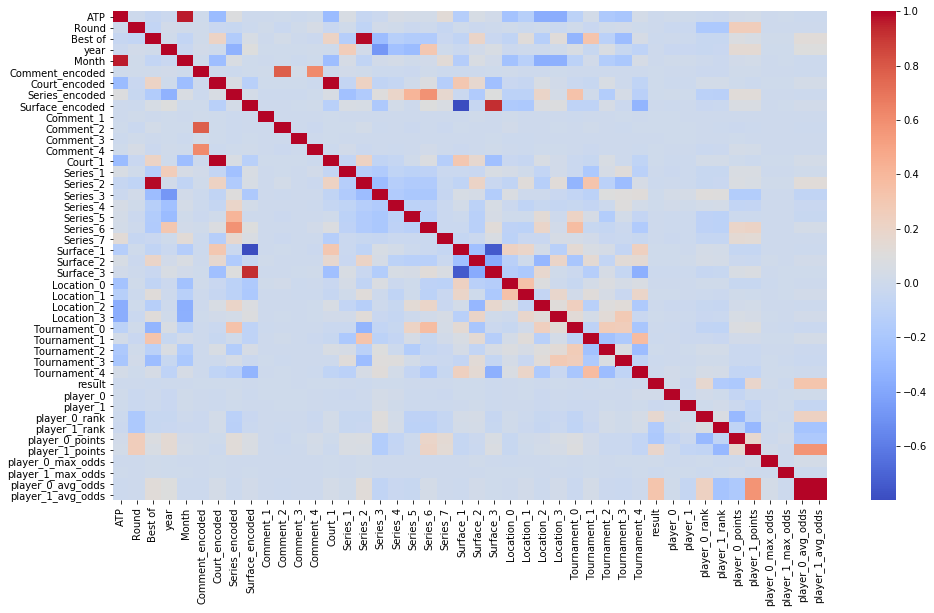

In [97]:
plt.figure(figsize=(16,9))
sns.heatmap(df_atp.corr(),cmap="coolwarm")

In [98]:
correlationFeatures = list((df_atp.corr()\
    ["result"] # Only get the correlation with the "Result"
    .apply(abs) # Apply the absolute value to extract the inverse correlation  
    .sort_values(ascending=False) # Sort the values
    [1:10]).index) # Eliminate the First (since it's the Revenue itself) and get the first 5 features

In [99]:
correlationFeatures

['player_1_avg_odds',
 'player_0_avg_odds',
 'player_0_points',
 'player_1_points',
 'player_0_rank',
 'player_1_rank',
 'player_0',
 'player_1',
 'player_0_max_odds']

* PCA

In [103]:
# Get the 2 components
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df_atp.loc[:, df_atp.columns != 'result'])
df_atp = pd.concat([df_atp, pd.DataFrame(pca_features,columns=["pca1", "pca2"])], axis=1)
pca_features_test = pca.transform(test.loc[:, test.columns != 'result'])
test = pd.concat([test, pd.DataFrame(pca_features_test,columns=["pca1", "pca2"])], axis=1)

In [105]:
pcaFeatures= ["pca1", "pca2"]

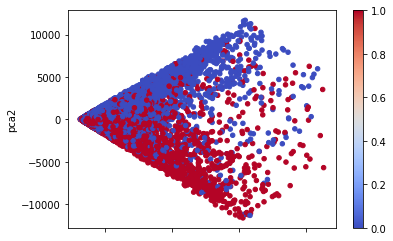

In [106]:
df_atp.plot.scatter(x="pca1",y="pca2",c=df_atp["result"],cmap="coolwarm")

### 2. Modeling

We will try 4 models:
    1. Logistic Regression
    2. Decision Trees
    3. Random Forests
    4. XGBoost

First, we need to separate the dataset into features and labels

In [107]:
y_train = df_atp['result']
x_train = df_atp.drop(['result'],axis=1)

y_test = test['result']
x_test = test.drop(['result'],axis=1)

#### 2.1. Logistic regression

In [108]:
def try_logistic_model(x_train, y_train, x_test, y_test, features):
    
    # Use only the features we selected
    x_train = x_train[features]
    x_test = x_test[features]
    
    # Use the pipeline in order to take adventage of the cross validation and the normalization of the data
    # using the StandartScaler
    steps = [('scaler', StandardScaler()), ('LogisticRegression', LogisticRegression())]
    pipeline = Pipeline(steps)
    grid = GridSearchCV(pipeline,param_grid=dict(),cv=3,scoring= 'accuracy')
    grid.fit(x_train, y_train)
        
    # Predicting the test
    y_pred = grid.predict(x_test)
    #Printing the accuracy and the classification report
    print("The accuracy is {}".format(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test,y_pred))


* All the features

In [109]:
try_logistic_model(x_train, y_train, x_test, y_test,allFeatures)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

The accuracy is 0.672865275142315
              precision    recall  f1-score   support

           0       0.64      0.76      0.70      1293
           1       0.72      0.59      0.65      1342

    accuracy                           0.67      2635
   macro avg       0.68      0.67      0.67      2635
weighted avg       0.68      0.67      0.67      2635



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


* Corrolated features

In [110]:
try_logistic_model(x_train, y_train, x_test, y_test,correlationFeatures)

The accuracy is 0.6732447817836812
              precision    recall  f1-score   support

           0       0.64      0.76      0.70      1293
           1       0.72      0.59      0.65      1342

    accuracy                           0.67      2635
   macro avg       0.68      0.67      0.67      2635
weighted avg       0.68      0.67      0.67      2635



* PCA components 

In [111]:
try_logistic_model(x_train, y_train, x_test, y_test,pcaFeatures)

The accuracy is 0.6504743833017078
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      1293
           1       0.66      0.64      0.65      1342

    accuracy                           0.65      2635
   macro avg       0.65      0.65      0.65      2635
weighted avg       0.65      0.65      0.65      2635



#### 2.2. Decision tree

In [112]:
def try_decision_tree(x_train, y_train, x_test, y_test, features):
    
    # Use only the features we selected
    x_train = x_train[features]
    x_test = x_test[features]
    
    steps = [('scaler', StandardScaler()), ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=0, max_depth=7))]
    pipeline = Pipeline(steps)
    grid = GridSearchCV(pipeline,param_grid=dict(),cv=10,scoring= 'accuracy')
    grid.fit(x_train, y_train)
    
    # Predicting the test
    y_pred = grid.predict(x_test)
    #Printing the accuracy
    print("The accuracy is {}".format(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test,y_pred))

* All the features

In [113]:
try_decision_tree(x_train, y_train, x_test, y_test,allFeatures)

The accuracy is 0.6827324478178368
              precision    recall  f1-score   support

           0       0.66      0.71      0.69      1293
           1       0.70      0.65      0.68      1342

    accuracy                           0.68      2635
   macro avg       0.68      0.68      0.68      2635
weighted avg       0.68      0.68      0.68      2635



* Corrolated features

In [114]:
try_decision_tree(x_train, y_train, x_test, y_test,correlationFeatures)

The accuracy is 0.6755218216318786
              precision    recall  f1-score   support

           0       0.66      0.71      0.68      1293
           1       0.70      0.65      0.67      1342

    accuracy                           0.68      2635
   macro avg       0.68      0.68      0.68      2635
weighted avg       0.68      0.68      0.68      2635



* PCA components

In [115]:
try_decision_tree(x_train, y_train, x_test, y_test,pcaFeatures)

The accuracy is 0.647438330170778
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      1293
           1       0.65      0.65      0.65      1342

    accuracy                           0.65      2635
   macro avg       0.65      0.65      0.65      2635
weighted avg       0.65      0.65      0.65      2635



#### 2.3. Random forest

In [116]:
def try_random_forest(x_train, y_train, x_test, y_test, features):
    
    # Use only the features we selected
    x_train = x_train[features]
    x_test = x_test[features]
    
    steps = [('scaler', StandardScaler()), ('RandomForestClassifier', RandomForestClassifier(random_state=0, n_estimators=30, max_depth=6))]
    pipeline = Pipeline(steps)
    grid = GridSearchCV(pipeline,param_grid=dict(),cv=10,scoring= 'accuracy')
    grid.fit(x_train, y_train)
    
    # Predicting the test
    y_pred = grid.predict(x_test)
    print("The accuracy is {}".format(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test,y_pred))

* All the features

In [117]:
try_random_forest(x_train, y_train, x_test, y_test,allFeatures)

The accuracy is 0.6781783681214422
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1293
           1       0.69      0.67      0.68      1342

    accuracy                           0.68      2635
   macro avg       0.68      0.68      0.68      2635
weighted avg       0.68      0.68      0.68      2635



* Corrolated features

In [118]:
try_random_forest(x_train, y_train, x_test, y_test,correlationFeatures)

The accuracy is 0.6755218216318786
              precision    recall  f1-score   support

           0       0.66      0.69      0.68      1293
           1       0.69      0.66      0.68      1342

    accuracy                           0.68      2635
   macro avg       0.68      0.68      0.68      2635
weighted avg       0.68      0.68      0.68      2635



* PCA Components

In [119]:
try_random_forest(x_train, y_train, x_test, y_test,pcaFeatures)

The accuracy is 0.6489563567362429
              precision    recall  f1-score   support

           0       0.64      0.65      0.65      1293
           1       0.66      0.64      0.65      1342

    accuracy                           0.65      2635
   macro avg       0.65      0.65      0.65      2635
weighted avg       0.65      0.65      0.65      2635



#### 2.4. XGBoost

In [120]:
def try_xgboost(x_train, y_train, x_test, y_test, features):
    
    # Use only the features we selected
    x_train = x_train[features]
    x_test = x_test[features]
    
    steps = [('scaler', StandardScaler()), ('RandomForestClassifier', XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05))]
    pipeline = Pipeline(steps)
    grid = GridSearchCV(pipeline,param_grid=dict(),cv=10,scoring= 'accuracy')
    grid.fit(x_train, y_train)
    
    # Predicting the test
    y_pred = grid.predict(x_test)
    
    print("The accuracy is {}".format(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test,y_pred))


* All features

In [121]:
try_xgboost(x_train, y_train, x_test, y_test,allFeatures)

The accuracy is 0.6766603415559772
              precision    recall  f1-score   support

           0       0.66      0.69      0.68      1293
           1       0.69      0.66      0.68      1342

    accuracy                           0.68      2635
   macro avg       0.68      0.68      0.68      2635
weighted avg       0.68      0.68      0.68      2635



* Corrolated features

In [122]:
try_xgboost(x_train, y_train, x_test, y_test,correlationFeatures)

The accuracy is 0.6800759013282732
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1293
           1       0.69      0.67      0.68      1342

    accuracy                           0.68      2635
   macro avg       0.68      0.68      0.68      2635
weighted avg       0.68      0.68      0.68      2635



* PCA Components

In [123]:
try_xgboost(x_train, y_train, x_test, y_test,pcaFeatures)

The accuracy is 0.6485768500948766
              precision    recall  f1-score   support

           0       0.64      0.65      0.65      1293
           1       0.66      0.65      0.65      1342

    accuracy                           0.65      2635
   macro avg       0.65      0.65      0.65      2635
weighted avg       0.65      0.65      0.65      2635

